## Linear Supervised Learning Series

# Part 6: Linear multiclass classification

In this post we discuss a popular alternative to OvA multiclass classification - detailed in the previous post - where we also learn $C$ two class classifiers (and also employ the fusion rule) but train them *simultaneously* instead of independently as with OvA.  This approach is the direct generalization of two-class classification to the multiclass setting, and so like two-class classification can be derived from a number of perspectives.  We will first use the *perceptron* perspective in our derivations, followed by a discussion of the *logistic regression* perspective.  These discussions culminate in the description of a single cost function for multiclass classification thaat - when minimized properly - provides similar results to OvA.  This cost function is widely used and goes by many names - e.g., *multiclass perceptron*,  *multiclass softmax classification*, *softmax regression*, and *multiclass logistic regression*.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  Multiclass perceptron and logistic regression

As we have just seen, in the OvA framework we learn $C$ linear classifiers separately and fuse them afterwards to create a final assignment rule for the entire space. The popular alternative we describe here - a direct generalization of two-class perceptron classifier to the multiclass setting - determines the $C$ classifiers jointly by learning all of their parameters simultaneously using a single function based on the fusion rule.  Given our previous discussion of OvA this is the most natural perspective to take (i.e., examining the classification problem 'from above' as opposed to thinking of it equivalently as a surface fitting nonlinear regression problem), although fundamentally one may equally well begin from the surface fitting logistic regression perspective to derive precisely what we end up with here (just as in the two-class case).

Because we have already done the work in deriving the fusion rule we can derive the basic concept and cost function almost immediately.  We will then see - as with our two-class classification perceptron - that it is common-place to 'soften' the initial cost function to allow for more stable optimization using the softmax approximation.  This leads to a cost function that also arises  *multiclass logistic regression*.

## 1.1 The multiclass perceptron

Once again we deal with an arbitrary multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consists of $C$ distinct classes of data, where label values $y_{p}\in\left\{ 1,2,...,C\right\} $.  In our previous post on OvA multiclass classification we saw how the fusion rule rightfully defined class ownership, partitioning the input space of a dataset given its classes in a fair way.  In particular the fusion rule gives us predicted labels for our dataset, the $p^{th}$ of which $\hat y_p$ given as

\begin{equation}
\hat y_p =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

where note the normal vectors here were normalized to be unit length i.e., $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j=1,..,C$.

For this prediction to be true for the $p^{th}$ point then our prediction matches the true label $\hat y_p = \overset{\mathstrut}{y_p} = c$, and so that the $c^{th}$ classifier provides the maximum evaluation of $\mathbf{x}_p$ as

\begin{equation}
w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

Remember geometrically this simply says that the distance from the point $\mathbf{x}_p$ to its class decision boundary is greater than its distance from every other class's (which, as we saw in the derivation of OvA means that $\mathbf{x}_p$ should belong to the $\left(y_p\right)^{th}$ class).

This is what we want for all of our training datapoints - to have the prediction provided by the fusion rule match our given labels, and hence the above to be true for every point $\mathbf{x}_p$.

Now, suppose we have *not* yet tuned our $C$ two-class classifiers optimally but keep the length of all $C$ normal vectors fixed at unit length so that we can reliably compute and compare distances to each boundary across the input space. We still know the sort of relationship that we *want* our set of $C$ two-class classifiers to have when optimally tuned.

By definition - when these weights are are tuned optimally - the right hand side of equation (2) must always be greater than or equal to the left - since the $c^{th}$ classifier is considered in the maximum on the right hand side.  This means that their difference - subtracting $ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}$ from both sides - is always greater than or equal to zero

\begin{equation}
\underset{j=1,...,C}{\text{max}} \,\,\,\left(w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}\right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \geq 0.
\end{equation}

Note here how equality $=0$ occurs when we have what we want - where the weights $\left(w_0^{(y_p)}, \, \mathbf{w}_{\mathstrut}^{(y_p)}\right)$ have been tuned correctly so that indeed the $y_p^{th}$ classifier provides the largest evaluation of $\mathbf{x}_p$ (in other words, $\mathbf{x}_p$ is furthest from its own class decision boundary as desired).  And we want equality to occur for all of our datapoints, that is we want their *sum* - written as follows - to equal zero (provided the weights of all $C$ classifiers are tuned correctly)

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = \sum_{p = 1}^P \left[\,\underset{j=1,...,C} {\text{max}} \,\,\,\left(w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]
\end{equation}

We call this the *multiclass perceptron cost* due to the fact that it is a direct generalizationn of the two-class perceptron discussed in a previous post: i.e., when $C = 2$ it can be shown to equivalent the two-class perceptron we saw previously (we show this in the appendix of this post).  Note how this cost function is a sum of rectified linear unit functions - like the simple example discussed in Example 5 of our post on gradient descent - and is convex.  Also note how in minimizing this cost we should - at least formally - subject it to the constraints that all normal vectors are unit length i.e., $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$  for $j=1,...,C$.  Remember - we need these normal vectors to be unit length if we are to fairly compare the distance of each input $\mathbf{x}_p$ to our two-class decision boundaries.  

Thus we have a proper *constrained optimization* problem on our hands that formally looks like 

\begin{equation}
\begin{aligned}
\underset{w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},\,...,\,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}}{\,\,\,\,\,\,\,\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \sum_{p = 1}^P \left[\,\underset{j=1,...,C} {\text{max}} \,\,\,\left(w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right]\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1 \,\,\,\,\text{for } j=1,...,C
\end{aligned}
\end{equation}

is a proper cost function for *determining* proper weights for our $C$ classifiers - it is always nonnegative, we want to find weights so that its value is small, and it precisely zero when all training points are classified correctly.  We can solve such problems directly in a variety of ways - e.g., by using projected gradient descent - but it more commonplace to see the problem approximately solved by *relaxing the constraints*.

Doing this we can phrase this constrained problems in an unconstrained *regularized* form by relaxing the constraints but penalyzing their magnitude.  Because we have $C$ constraints we could in theory provide a distinct penalty (or regularization parameter) $\lambda_j$ for each constraint.  However for the sake human usability (so we need only provide one regularization value, and not $C$ distinct regularization parameters every time we use this approach) it is commonplace to simply chooses a single regularization parameter $\lambda \geq 0$ that is used to penalize the magnitude of all normal vectors simultaneously.  This gives a regularized form of the above problem as

\begin{equation}
\underset{w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}}{\text{minimize}} \,\, \sum_{p = 1}^P \left[\,\underset{j=1,...,C} {\text{max}} \,\,\,\left(w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right) - \left(w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right) \right] + \lambda \sum_{j = 1}^{C} \left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 
\end{equation}

While this regularized form does not quite match the original constrained formulation as regularizing all normal vectors together will not necessarily force guarantee that $\left \Vert \mathbf{w}_{\mathstrut}^{(\,j)} \right \Vert_2^2 = 1$ for all $j$.  However it will generally force the length of all normal vectors to behave well (e.g., disallowing one normal vector to grow arbitrarily large while one shrinks to almost nothing) in practice and -
as we see many times in machine learning - it is 'close enough' to the original and works well in practice with $\lambda$ typically set to a small value (e.g., $10^{-3}$ and smaller).

#### <span style="color:#a50e3e;">Example 1: </span> Multiclass perceptron

I this example we minimize the regularized multiclass classifier defined above over the $C = 3$ class toy dataset used in deriving OvA in the previous post.

<IPython.core.display.Javascript object>


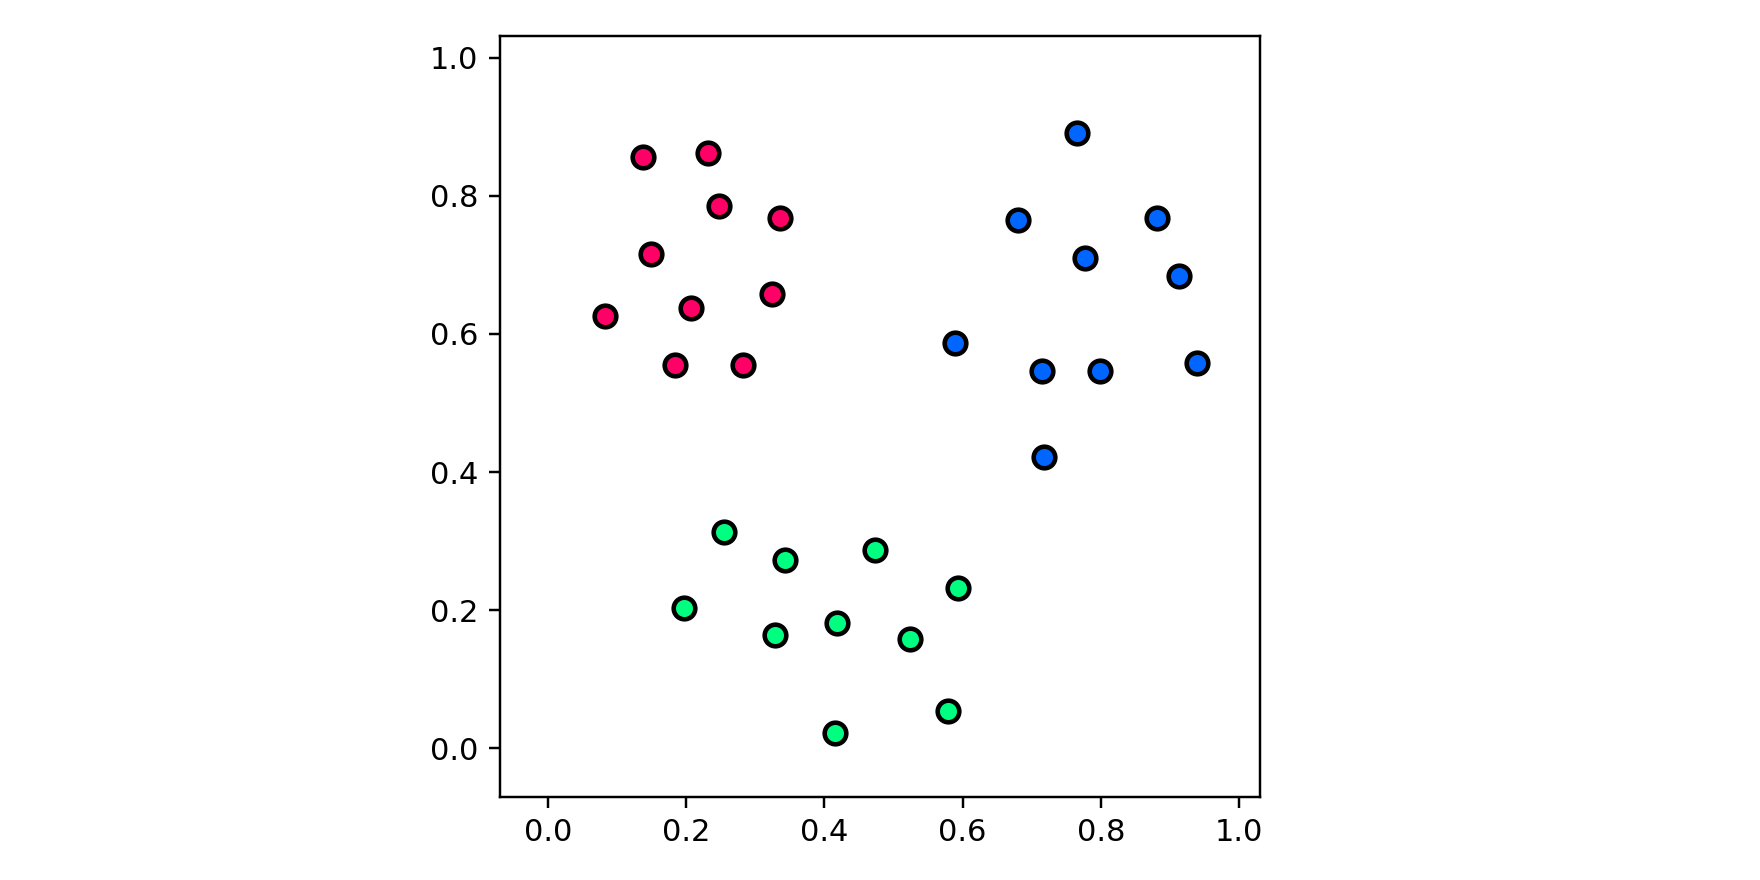

In [24]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

Next we parse out the input from output, and form the regularized cost function.  

In [25]:
# define the input and output of our dataset
x = np.asarray(data[:,:-1])
x.shape = (len(x),np.shape(data)[1]-1); x = x.T;
y = data[:,-1]
y.shape = (len(y),1)

One is free to implement the cost function here in a number of ways.  Note however that in the particular implementation shown here the weights from all $C$ classifiers are input as an $\left(N + 1, C \right)$ array of the form

\begin{equation}
\mathbf{W} = 
\begin{bmatrix}
w_0^{(1)} \,\, w_0^{(2)}, \cdots , w_0^{(C)} \\
\mathbf{w}^{(1)} \,\, \mathbf{w}^{(2)}, \cdots , \mathbf{w}^{(C)}
\end{bmatrix}
\end{equation}

where the bias and normal vector of the $c^{th}$ classifier have been stacked on top of one another and made the array's $c^{th}$ column.  Also note that the quantity $\left(w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)} \right)$ is pre-computed for all points prior to the summation and stored in a single array.

In [4]:
# multiclass perceptron regularized by the summed length of all normal vectors
lam = 10**-4  # our regularization paramter 
def multiclass_perceptron(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = int(y[p][0]) - 1    # subtract off one due to python indexing

        # update cost summand
        cost +=  max(all_evals[p,:]) - all_evals[p,y_p]
        
        # return cost with regularizer added
    return cost + lam*np.linalg.norm(W[1:,:],'fro')**2

This function is *always convex* - which can be shown to be true mathematically - hence we can use the unnormalized form of gradient descent to minimize it.  

In [9]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,4)
w_hist = opt.gradient_descent(g = multiclass_perceptron,w = W_init,version = 'unnormalized',max_its = 300, alpha = 10**-2)

With our multiclass classifier trained we show how it classifies the entire input space in the two panels below.  In the left panel we also plot each individual two-class classifier the color of its class.  In the right panel we show the fused multiclass decision boundary formed by combining these individual classifiers via the fusion rule.

Note in the left panel that because we did not train each individual classifier in an OvA sense - but trained them together all at once - each individual learned two-class classifier performs quite poorly.  This is fine - our cost function aimed at minimizing all errors of every class simultaneously - not two at a time as with OvA - so we need not expect each individual classifier to cut the space well.  However since they were learned together their combination - using the fusion rule - provides a multiclass decision boundary with zero errors.

<IPython.core.display.Javascript object>


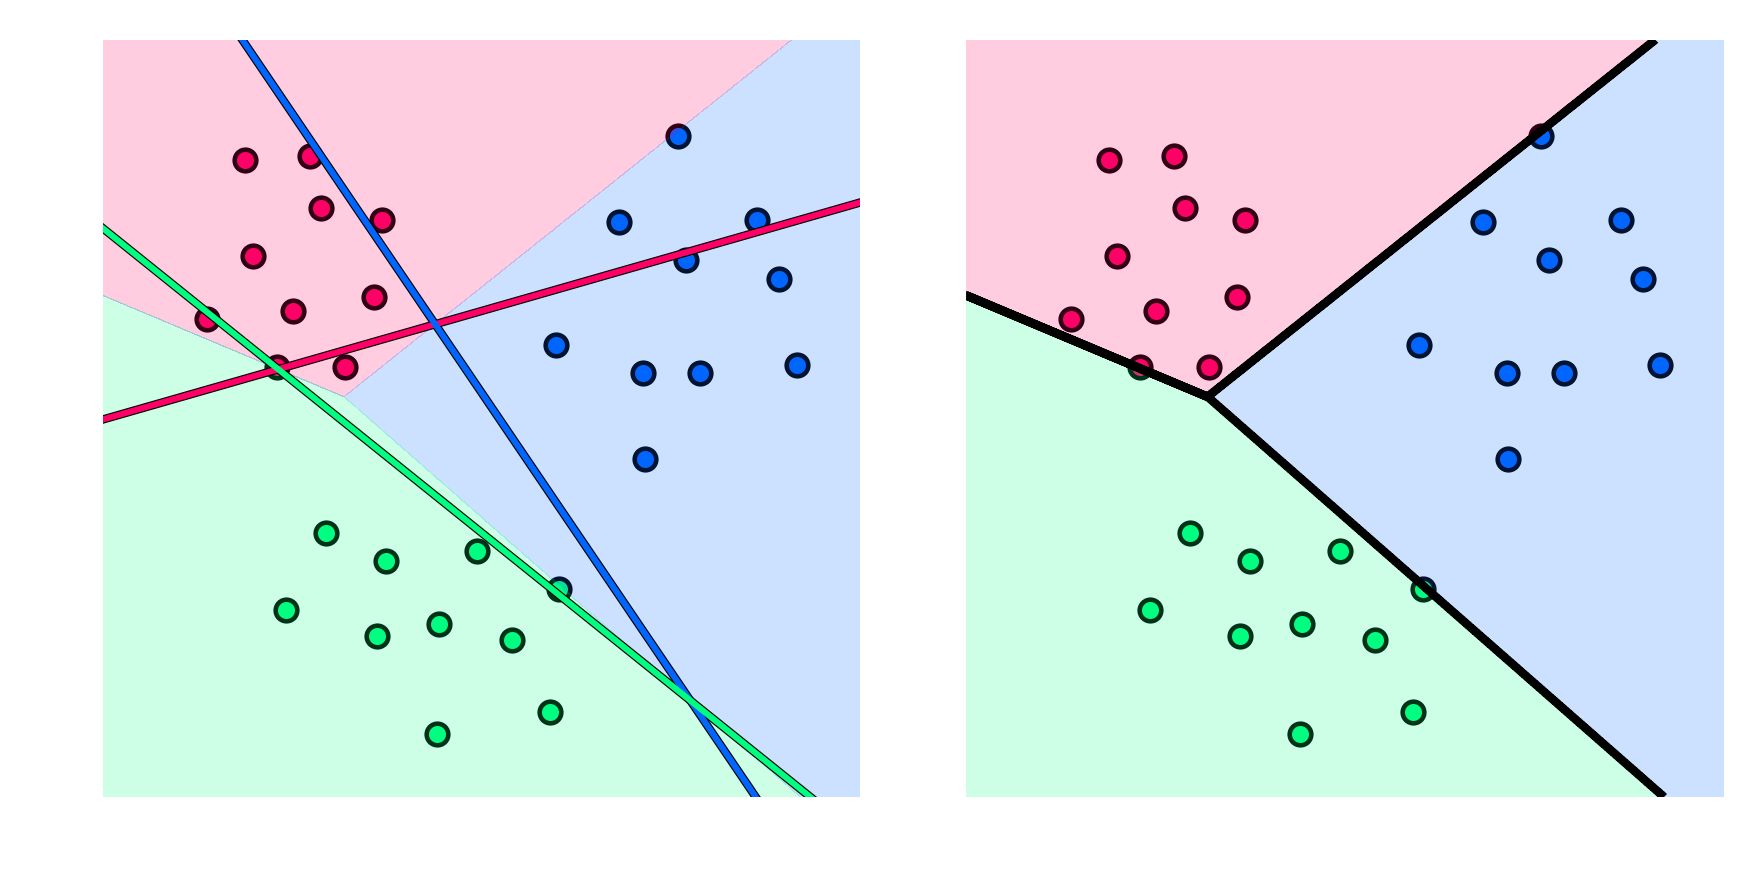

In [10]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (right panel)
demo.show_complete_coloring(w_hist)

## 1.2  The smooth softmax approximation multiclass perceptron cost

As we saw previously e.g., with the two-class perceptron, we are often we are willing to sacrifice a small amount of modeling precision - forming a closely matching smoother cost function to the one we already have - in order to make optimization easier / expand the optimization tools we can bring to bear. 

Recall from our discussion of the two-class perceptron the *softmax function* - a close and smooth approximation to the maximum of $C$ scalar numbers $s_{1},...,s_{C}$ written as

\begin{equation}
\text{max}\left(s_{1},...,s_{C}\right) \approx \text{soft}\left(s_{1},...,s_{C}\right)
\end{equation}

where

\begin{equation}
\text{soft}\left(s_{1},...,s_{C}\right)=\text{log}\left(\sum_{j = 1}^{C} e^{s_{j}}\right).
\end{equation}

(note here that 'log' is the natural log with base e) Replacing both 'max' functions in each summand of the multiclass perceptron cost in equation (4) (leaving asside the regularizer for now) we have the *softmax multiclass cost function*

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = \sum_{p = 1}^P \left[\text{log}\left( \sum_{j = 1}^{C}  e^{ w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}}  \right) - \left( w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}\right)\right].
\end{equation}

As with the mutliclass perceptron - the multiclass softmax cost reduces to the two-class version when $C = 2$ (see the appendix of this post for further details).

One often sees this cost function go by many names - e.g., *softmax regression* and *multiclass logistic regression* - for as with two-class classification the softmax cost can be interpreted from a logistic regression (surface fitting) perspective.  One also often sees the cost written in various ways in practice as well - sometimes due to the perspective taken in deriving it, or for numerical stability reasons.  A very common alternative way one will see the softmax multiclass cost function written (when thought of from the perspective of logistic regression) can be seen by using basic properties of the log function.  Using the following properties 

\begin{array}
\text{log}(s\cdot t) = \text{log}(s) + \text{log}(t) \\
\text{log}(s)^{-1} = \text{log}\left(\frac{1}{s}\right)
\end{array}

one can express the softmax multiclass cost in equation (10) equivalently as

\begin{equation}
g\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)},...,w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)} \right) = -\sum_{p = 1}^P \text{log}\left(\frac{ e^{ w_0^{(y_p)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(y_p)}} }{ \sum_{j = 1}^{C}  e^{ w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}} }\right)        .
\end{equation}

 

Writing the softmax cost in this particular manner can however potentially introduce numerical issues while optimizing.  This is due to the exponential 'overflowing' with large exponents, like e.g., $e^{1000}$, as these numbers are too large to store explicitly on the computer and so are represented symbolically as $\infty$. This becomes a problem when dividing two exponentials like e.g., $\frac{e^{1000}}{1+e^{1000}}$
which, although basically equal to the value $1$, is thought of by the computer to be a NaN (not a number) as it thinks $ $$\frac{e^{1000}}{1+e^{1000}}=\frac{\infty}{\infty}$ which is undefined. By writing each summand in the form shown in equation (10) we can guard against this potentiality.  

#### <span style="color:#a50e3e;">Example 2: </span> Multiclass softmax on $C =3$ toy dataset

In [26]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**-3  # our regularization paramter 
def multiclass_softmax(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = int(y[p][0]) - 1    # subtract off one due to python indexing

        # update cost summand
        cost +=  np.log(np.sum(np.exp(all_evals[p,:]))) - all_evals[p,y_p]
        
        # return cost with regularizer added
    return cost + lam*np.linalg.norm(W[1:,:],'fro')**2

In [27]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,3)
w_hist = opt.gradient_descent(g = multiclass_softmax,w = W_init,version = 'unnormalized',max_its = 500, alpha = 10**-2)

<IPython.core.display.Javascript object>


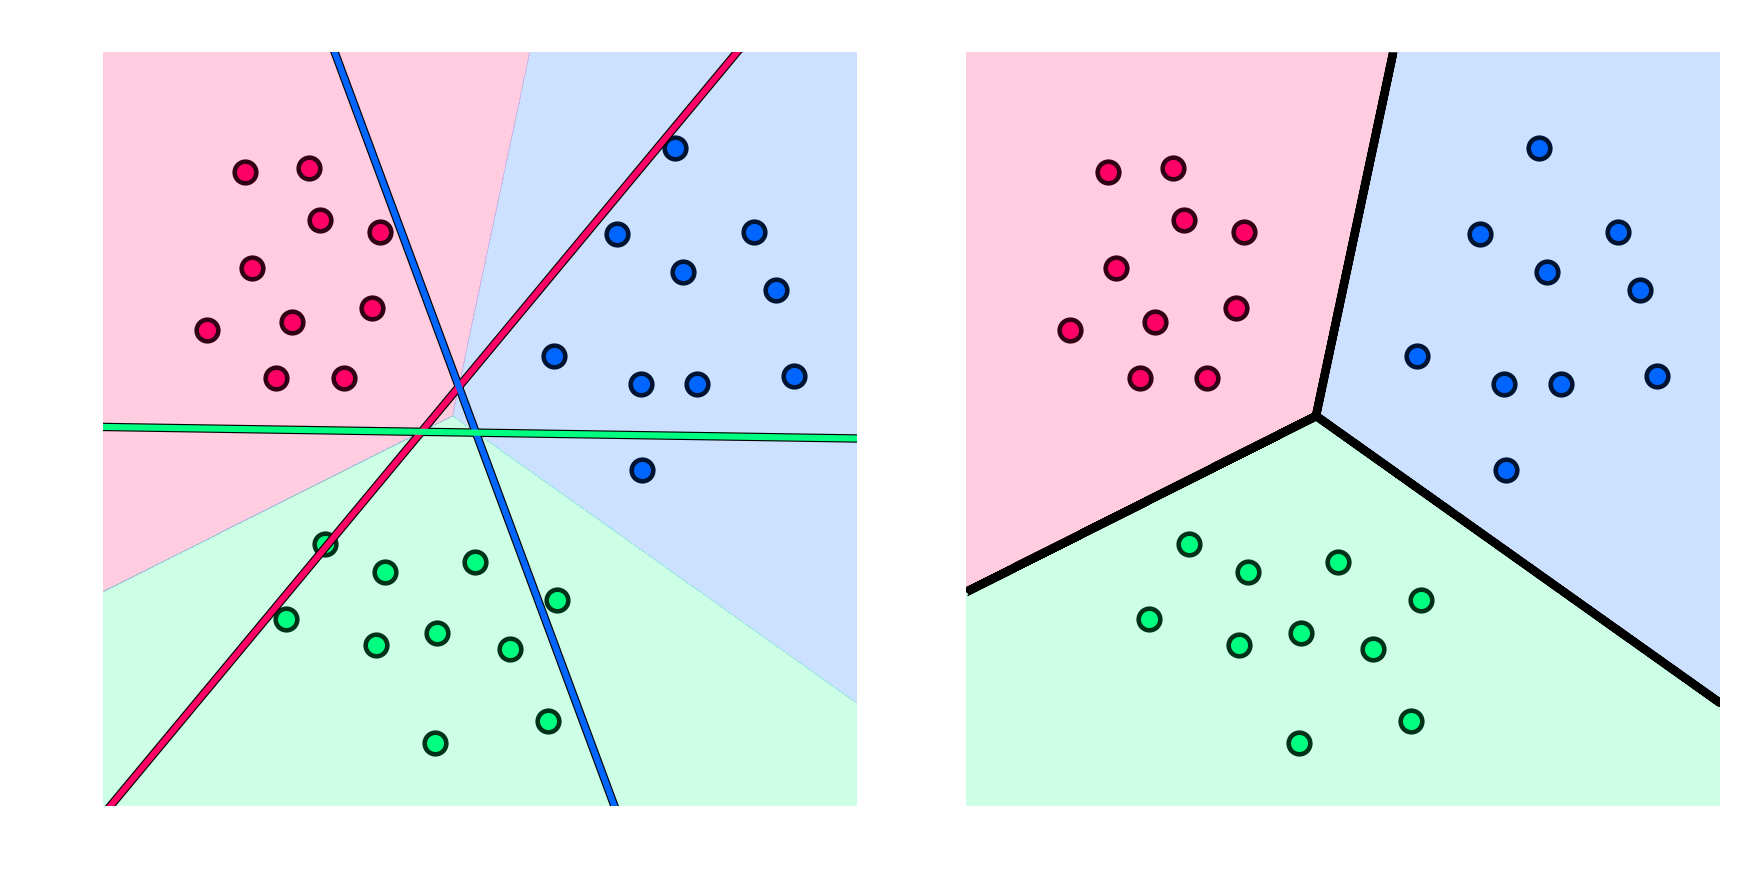

In [28]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (right panel)
demo.show_complete_coloring(w_hist)

#### <span style="color:#a50e3e;">Example 3: </span> Multiclass softmax on $C = 4$ class dataset

<IPython.core.display.Javascript object>


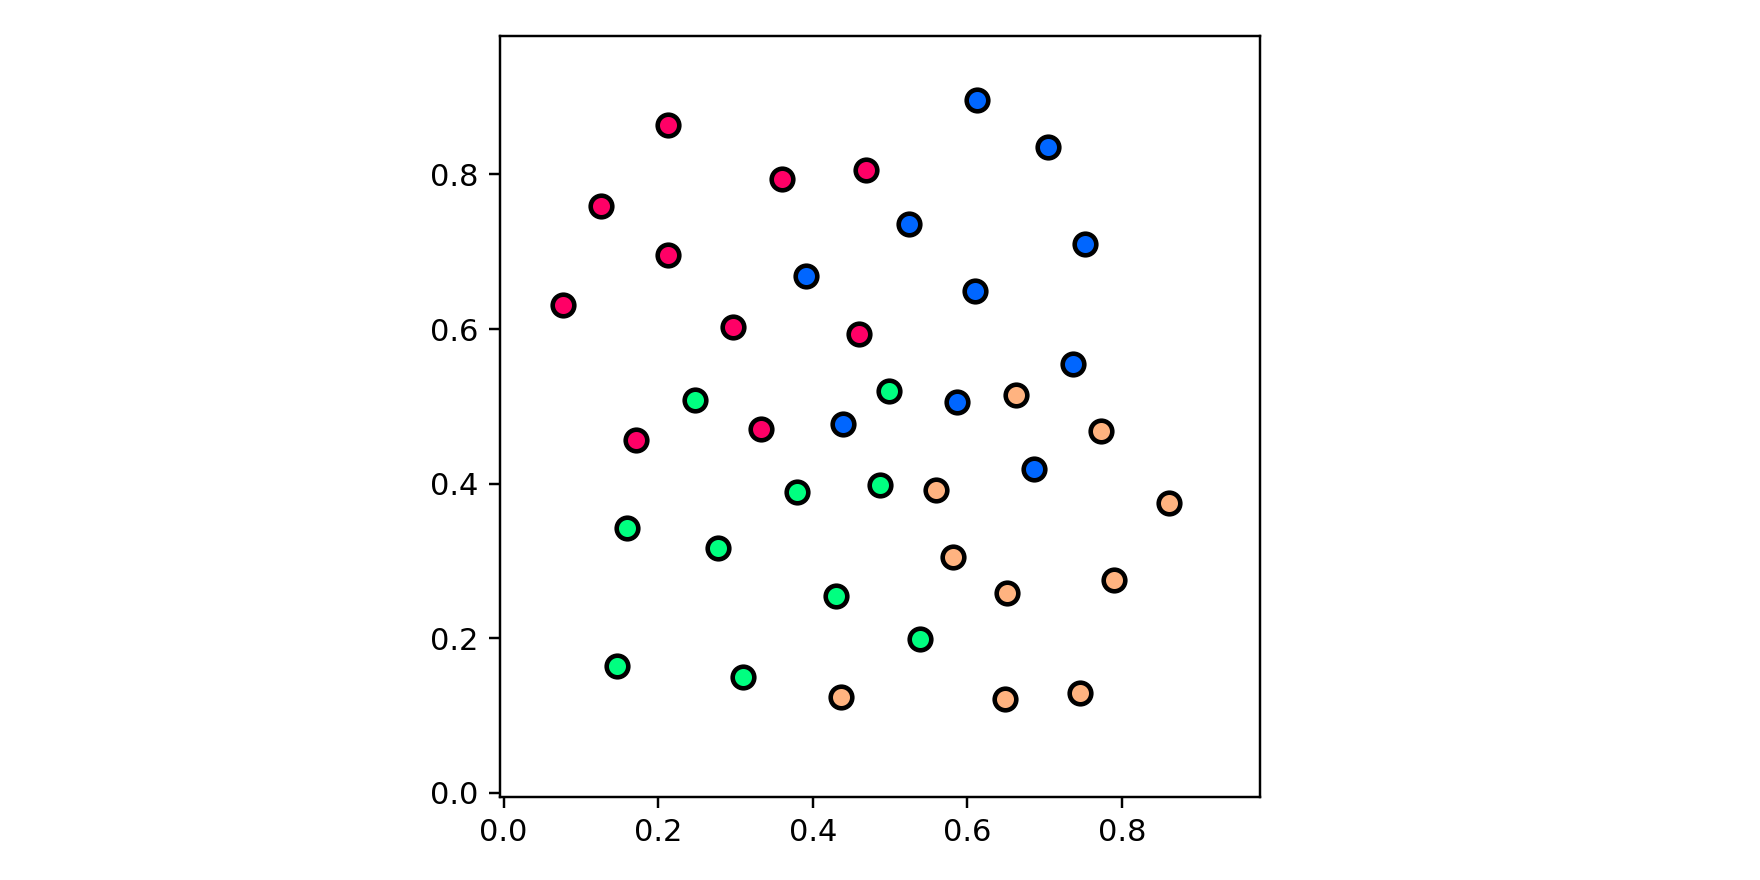

In [15]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/4class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

In [17]:
# define the input and output of our dataset
x = np.asarray(data[:,:-1])
x.shape = (len(x),np.shape(data)[1]-1); x = x.T;
y = data[:,-1]
y.shape = (len(y),1)

In [19]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**-3  # our regularization paramter 
def multiclass_softmax(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label
        y_p = int(y[p][0]) - 1    # subtract off one due to python indexing

        # update cost summand
        cost +=  np.log(np.sum(np.exp(all_evals[p,:]))) - all_evals[p,y_p]
        
        # return cost with regularizer added
    return cost + lam*np.linalg.norm(W[1:,:],'fro')**2

In [22]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,4)
w_hist = opt.gradient_descent(g = multiclass_softmax,w = W_init,version = 'unnormalized',max_its = 500, alpha = 10**-2)

<IPython.core.display.Javascript object>


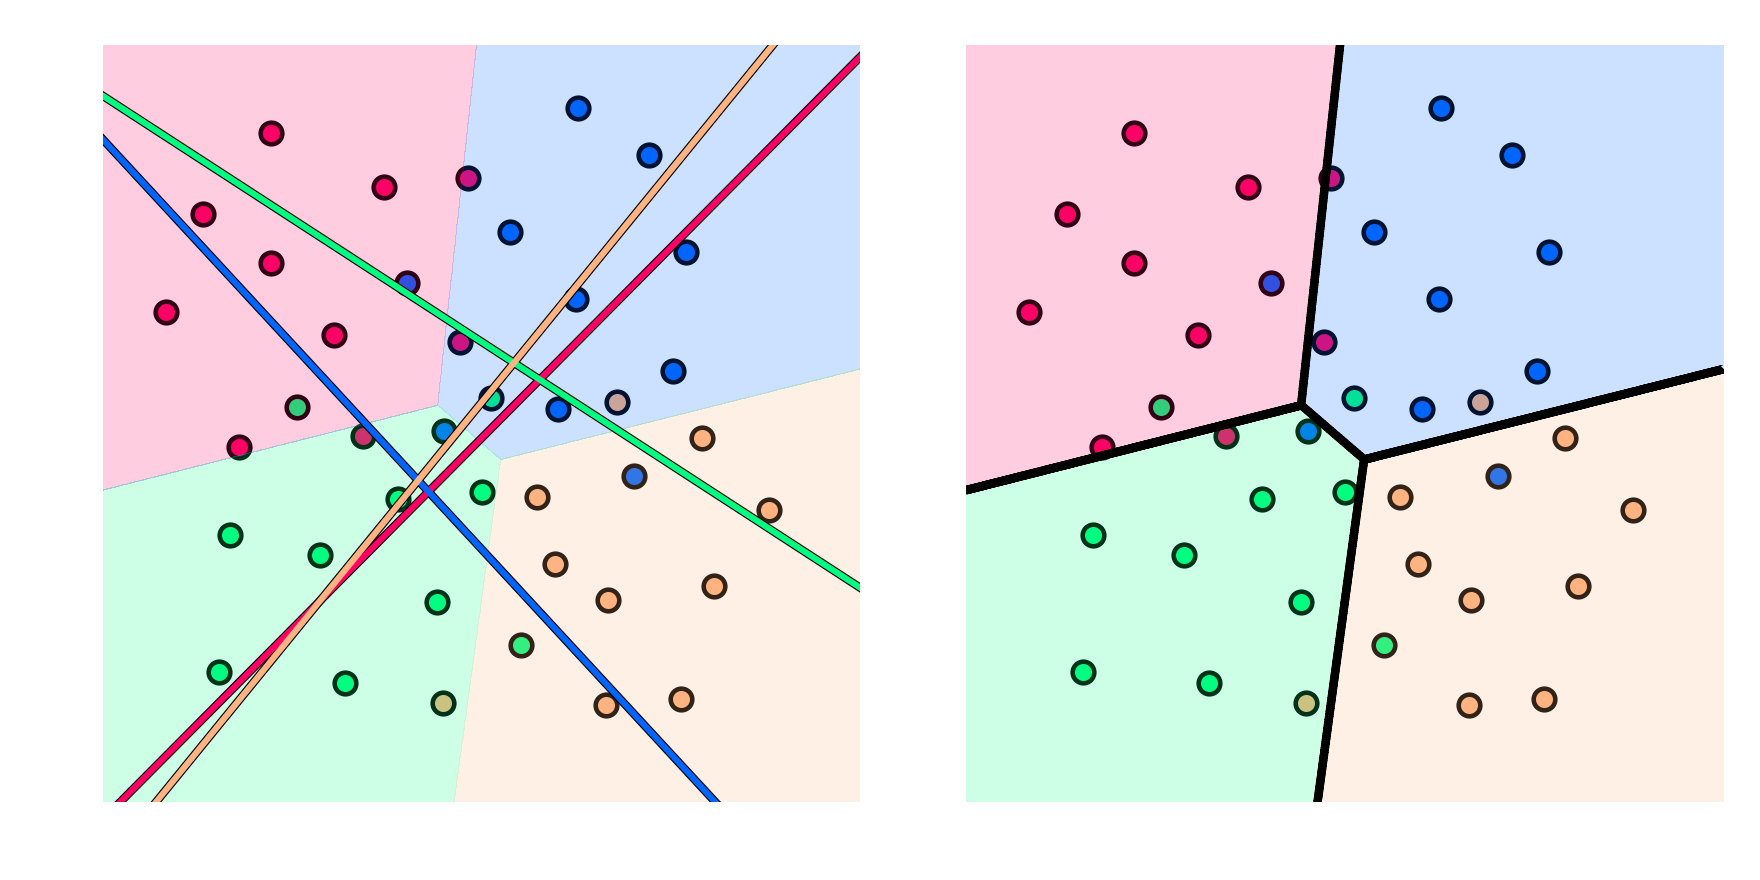

In [23]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (right panel)
demo.show_complete_coloring(w_hist)

## 1.4  Surface fitting interpretation 

## 1.5  Comparing cost function and counting cost values

## 1.7  Counting misclassifications and the accuracy of a multiclass classifier

Once trained we can compute predicted labels for our training set by simply evaluating each input via the fusion rule.  Taking the input of the $p^{th}$ point $\left(\mathbf{x}_p,\,y_p\right)$ we use the fusion rule to produce a predicted output $\hat y_p$ as

\begin{equation}
\hat y_p =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

and then simply compare the actual and predicted labels to understand if our prediction is correct.  One way to write this comparison is $\left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p} \right) \right |$, which is $0$ if the prediction matches the true label and $+1$ otherwise.  We can then write the total number of misclassifications on our training set as

\begin{equation}
\text{number of misclassifications on training set } = \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}

with the accuracy being then calculated as 

\begin{equation}
\text{accuracy of learned classifier} = 1 - \frac{1}{P} \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}

## Which is better?

# Appendix

## Proof that multiclass perceptron reduces to two-class perceptron when $C = 2$

## Proof that multiclass logistic regression reduces to two-class logistic regression when $C = 2$

# proof of convexity of multiclass perceptron / softmax cost

# Lipschitz constant for softmax multiclass